# Github Performance Metrics- Issues

**Activity by Repo**

This notebook will aim to query the Augur DB to access the neccessary information to be able to get the following issue metrics dirived from the GitHub Community Metrics working document https://docs.google.com/document/d/1Yocr6fk0J8EsVZnJwoIl3kRQaI94tI-XHe7VSMFT0yM/edit?usp=sharing

Any necessary computations from the data to get the metric value will be done as the queries are determined

In [29]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)

with open("../../config_temp.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
#add your repo name(s) here of the repo(s) you want to query if known (and in the database)
repo_name_set = ['augur', 'grimoirelab']
repo_set = []

for repo_name in repo_name_set:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_name = \'{repo_name}\'
        """)

    t = engine.execute(repo_query)
    repo_id =t.mappings().all()[0].get('repo_id')
    repo_set.append(repo_id)
print(repo_set)

[25440, 25448]


In [4]:
#Take this out of quotes if you want to manually assign a repo_id number(s)
#repo_set = [25440]

## Query for Issue Analysis

In [5]:
df_issues = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    r.repo_name,
					i.issue_id AS issue, 
					i.gh_issue_number AS issue_number,
					i.gh_issue_id AS gh_issue,
					i.created_at AS created, 
					i.closed_at AS closed
                FROM
                	repo r,
                    issues i
                WHERE
                	r.repo_id = i.repo_id AND
                    i.repo_id = \'{repo_id}\'
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_issues = pd.concat([df_issues, df_current_repo])

df_issues = df_issues.reset_index()
df_issues.drop("index", axis=1, inplace=True)
        
df_issues.head()

,repo_name,issue,issue_number,gh_issue,created,closed
0,augur,340115,28,213149529,2017-03-09 20:06:18,2017-04-07 21:18:01
1,augur,343231,886,682259157,2020-08-20 00:09:30,2020-08-20 00:16:50
2,augur,343216,880,679627659,2020-08-15 19:11:45,2020-08-17 14:30:04
3,augur,343467,967,724668885,2020-10-19 14:21:08,2020-10-19 14:21:34
4,augur,342738,740,628534692,2020-06-01 15:34:33,2020-08-20 10:48:14


In [6]:
df_issues_comments = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    r.repo_name,
                    irm.issue_id,
                    irm.issue_msg_ref_id,
                    i.created_at,
                    m.msg_timestamp msg_time,
					m.msg_text comment_text
                FROM
                	repo r,
                    issues i,
                    issue_message_ref irm, 
                    message m 
                WHERE
                	m.msg_id = irm.msg_id AND
                    irm.issue_id = i.issue_id AND
                	i.repo_id = r.repo_id AND
                    r.repo_id = \'{repo_id}\'
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_issues_comments = pd.concat([df_issues_comments, df_current_repo])

df_issues_comments = df_issues_comments.reset_index()
df_issues_comments.drop("index", axis=1, inplace=True)
        
df_issues_comments.head()

,repo_name,issue_id,issue_msg_ref_id,created_at,msg_time,comment_text
0,augur,339455,1199959,2020-04-17 21:25:27,2018-08-11 20:49:22,Is there a reason requirements.txt was removed?
1,augur,339455,1199960,2020-04-17 21:25:27,2018-08-12 16:47:29,I did not intend to delete this file.
2,augur,339455,1199961,2020-04-17 21:25:27,2019-01-17 18:04:57,Was this a merge conflict resolution? I think...
3,augur,339455,1199962,2020-04-17 21:25:27,2019-01-17 18:16:36,"Actually, @gabe-heim had made this change earl..."
4,augur,339455,1199963,2020-04-17 21:25:27,2019-06-13 12:30:55,This was the error message I got: \r\nYou can ...


In [7]:
#IF YOU ONLY WANT TO LOOK AT A ONE OF THE REPOS QUERIED 
repo_focus = 'augur'
df_issues_focus = df_issues[df_issues['repo_name'] == repo_focus]
df_issues_focus = df_issues_focus.sort_values(by= "created")
df_issues_focus = df_issues_focus.reset_index(drop=True)

## Median Time to Close Issues
One of the performance metrics we would like to track is the median time taken to close issues. From the `issues` table, we have `created` and `closed` timestamps, the difference between the two will give us the time taken to close a given issue.

In [8]:
# Calculate the time taken to close an issue
df_issues_focus['time_to_close'] = (df_issues_focus.closed - df_issues_focus.created)

In [9]:
df_issues_focus.head()

,repo_name,issue,issue_number,gh_issue,created,closed,time_to_close
0,augur,340142,1,202159788,2017-01-20 14:56:01,2017-12-18 17:15:12,332 days 02:19:11
1,augur,340141,2,202161717,2017-01-20 15:04:01,2017-02-17 03:05:14,27 days 12:01:13
2,augur,340140,3,202232128,2017-01-20 20:15:51,2017-02-15 16:55:41,25 days 20:39:50
3,augur,340139,4,202606858,2017-01-23 18:00:23,2017-05-11 15:45:33,107 days 21:45:10
4,augur,340138,5,202618154,2017-01-23 18:50:08,2017-01-23 20:49:42,0 days 01:59:34


In [10]:
# The overal median time to close issues for the augur repo
df_issues_focus.time_to_close.median()

Timedelta('0 days 09:40:58')

Now let's find out the median time taken to close issues grouped by month.

In [11]:
df_issues_closed_monthly = df_issues_focus['time_to_close'].groupby(df_issues_focus.created.dt.to_period("M")).agg('median')

We can visualize the trend in median time to close issues by month

In [12]:
df_issues_closed_monthly = df_issues_closed_monthly.astype('timedelta64[D]')

### Line Plot

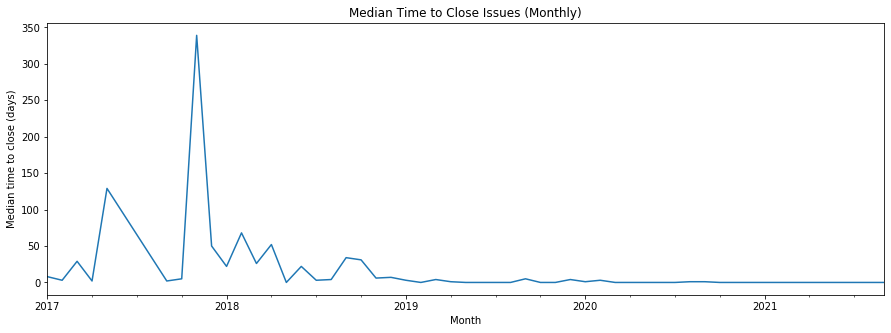

In [13]:
df_issues_closed_monthly.plot()
plt.xlabel("Month")
plt.ylabel("Median time to close (days)")
plt.title("Median Time to Close Issues (Monthly)")
plt.show()

We can also plot a bar graph as follows

## Bar Plot

Text(0.5, 1.0, 'Median Time to Close Issues (Monthly)')

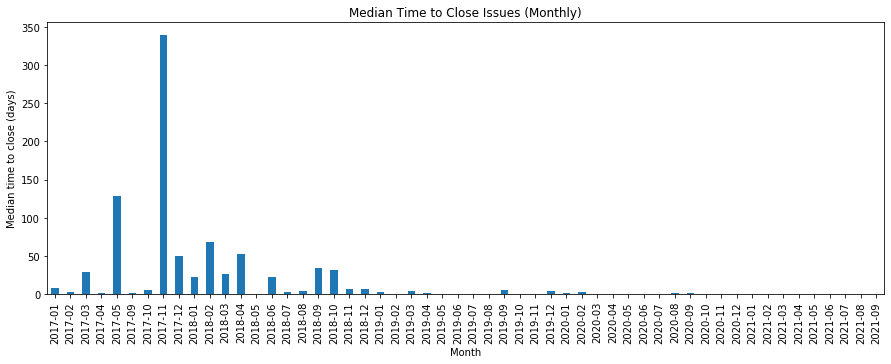

In [14]:
df_issues_closed_monthly.plot.bar()
plt.xlabel("Month")
plt.ylabel("Median time to close (days)")
plt.title("Median Time to Close Issues (Monthly)")

In [31]:
df_issues_focus['time_to_close'].describe()

count                          1351
mean     17 days 00:29:38.954108068
std      58 days 21:09:12.017033490
min                 0 days 00:00:07
25%                 0 days 00:02:16
50%                 0 days 09:40:58
75%                 6 days 19:29:25
max               692 days 02:45:18
Name: time_to_close, dtype: object

## Number of Issues Open
Let's now identify the issues which are still open and view them by the month they were openned originally

In [16]:
df_issues_open = df_issues_focus[df_issues_focus['closed'].isnull()]

In [17]:
df_issues_open = df_issues_open.reset_index(drop=True)

To find out how long an issue has been open, we can find the difference between the current timestamp and the issue creation timestamp

In [18]:
#Calculate the time an issue has been open
df_issues_open['time_open'] = (pd.Timestamp.now() - df_issues_open.created)

In [30]:
df_issues_open['time_open'].describe()

count                            101
mean     130 days 18:03:09.518855800
std      118 days 08:39:25.371506794
min           6 days 18:03:55.310935
25%          40 days 18:07:30.310935
50%          71 days 00:03:07.310935
75%         186 days 23:10:14.310935
max         514 days 01:34:43.310935
Name: time_open, dtype: object

Now, lets see the median time issues were open by month

In [20]:
df_issues_open_monthly = df_issues_open['created'].groupby(df_issues_open.created.dt.to_period("M")).agg('count')

We can visualize the median time issues are open with a bar graph

### Plot

Text(0, 0.5, 'Number of Issues')

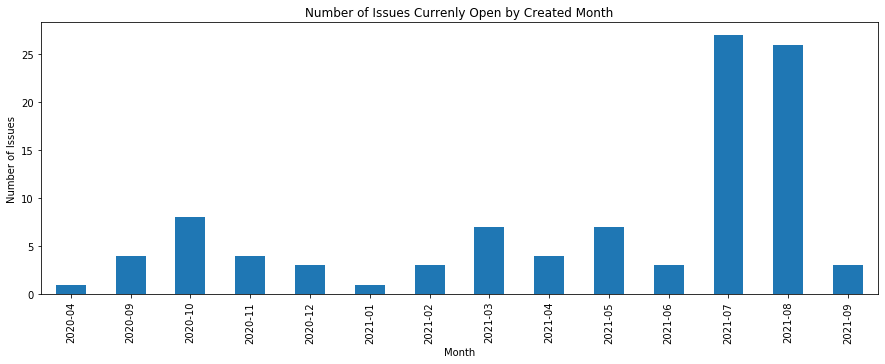

In [21]:
df_issues_open_monthly.plot.bar()
plt.title("Number of Issues Currenly Open by Created Month")
plt.xlabel("Month")
plt.ylabel("Number of Issues")

## Time to First Response Issues

In [22]:
df_issues_comments_focus = df_issues_comments[df_issues_comments['repo_name'] == repo_focus]
df_issues_comments_focus = df_issues_comments_focus.sort_values(by= "msg_time")
df_issues_comments_focus = df_issues_comments_focus.reset_index(drop=True)
df_issues_comments_focus = df_issues_comments_focus.drop_duplicates(subset='issue_id', keep='first')

In [23]:
not_answered = df_issues_focus.shape[0]-df_issues_comments_focus.shape[0]
answered = df_issues_comments_focus.shape[0]

### Pie Chart-Response Percent

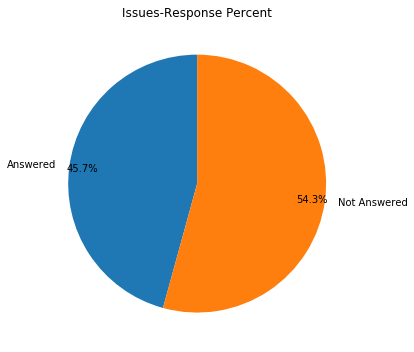

In [24]:
labels = ["Answered","Not Answered"]
sizes = [answered,not_answered]
plt.pie(sizes,autopct='%1.1f%%',startangle=90,pctdistance=0.9,labels=labels)
plt.title("Issues-Response Percent")
plt.tight_layout()
plt.show()

In [25]:
df_issues_comments_focus['time_to_response'] = (df_issues_comments_focus.msg_time - df_issues_comments_focus.created_at)
df_issues_comments_focus = df_issues_comments_focus[df_issues_comments_focus['time_to_response'] >= pd.Timedelta(0)]

In [26]:
df_issues_comments_monthly = df_issues_comments_focus['time_to_response'].groupby(df_issues_comments_focus.created_at.dt.to_period("M")).agg('mean')
df_issues_comments_monthly = df_issues_comments_monthly.astype('timedelta64[D]')

### Bar Plot- Mean Time to First Reponse
***Note: this is the time for only the issues that have a response***

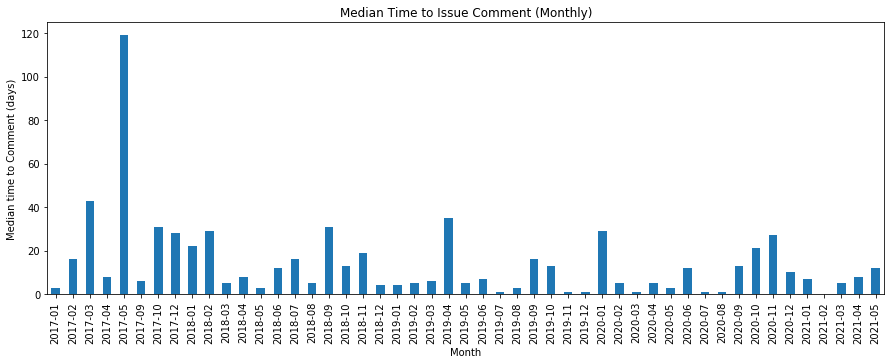

In [27]:
df_issues_comments_monthly.plot.bar()
plt.xlabel("Month")
plt.ylabel("Median time to Comment (days)")
plt.title("Median Time to Issue Comment (Monthly)")
plt.show()

In [28]:
df_issues_comments_focus.describe()

,issue_id,issue_msg_ref_id,time_to_response
count,572.000000,5.720000e+02,572
mean,376210.860140,1.204971e+06,10 days 06:48:15.858391608
std,113390.064602,8.001126e+03,28 days 08:16:20.265810224
min,339462.000000,1.199971e+06,0 days 00:00:17
25%,339728.750000,1.200566e+06,0 days 04:26:28.500000
50%,339945.500000,1.200936e+06,1 days 13:58:46.500000
75%,340139.250000,1.209160e+06,6 days 01:36:14.250000
max,734598.000000,1.225894e+06,241 days 12:57:16
